<H2 style="text-align: center">Bag of Visual Words Model</H2>

## Overview

The goal of this work is to develop an image recognition algorithm. Specifically, we will examine the task of scene recognition starting with very simple methods -- tiny images and nearest neighbor classification -- and then move on to more advanced methods -- bags of quantized local features and linear classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by models used in natural language processing. The model ignores or downplays word arrangement (spatial information in the image) and classifies based on a histogram of the frequency of visual words. The visual word "vocabulary" is established by clustering a large corpus of local features. See Szeliski chapter 14.4.1 for more details on category recognition with quantized features. In addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification techniques.

For this project you will be implementing a basic bag of words model. You will classify scenes into one of 15 categories by training and testing on the 15 scene database (introduced in [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of previously published datasets). [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great paper to read, although we will be implementing the baseline method the paper discusses (equivalent to the zero level pyramid) and not the more sophisticated spatial pyramid (which is extra credit). For an excellent survey of pre-deep-learning feature encoding methods for bag of visual words models see [Chatfield et al. 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations -- **tiny images** and **bags of visual features** -- and 2 different classification techniques -- **nearest neighbor** and **(non-)linear SVM**. In the writeup, you are specifically asked to report performance for the following combinations, and it is also highly recommended that you implement them in this order:

* Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).
* Bag of visual words representation and nearest neighbor classifier (accuracy of about 50-60%).
* Bag of visual words representation and linear SVM classifier (accuracy of about 60-70%).

**Acknowledgement:** This work is adapted from [Prof James Hays](https://www.cc.gatech.edu/~hays/) of Georgia Institute of Technology.

Although you will undoubtedly work collaboratively in the workshops themselves, these are **individual** exercises.  The reports you write should be about the results **you** obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism.

## Utils
First, lets have some useful functions

In [11]:
import os
import cv2
import glob
import pickle
import skimage
import warnings
import numpy as np
import os.path as osp
from skimage import io
from random import shuffle
from skimage import transform
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.spatial import distance
import scipy as sp
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import pandas as pd
from google.colab.patches import cv2_imshow
import math

# Skimage gives us some lossy conversion errors that we really don't care about
# so we suppress them
warnings.filterwarnings('ignore', '', UserWarning)

# Double to single precision
def im2single(im):
    im = im.astype(np.float32) / 255
    return im

# Single to double precision
def single2im(im):
    im *= 255
    im = im.astype(np.uint8)
    return im

# Load image
def load_image(path):
    return im2single(cv2.imread(path))[:, :, ::-1]

# Load image in grayscale
def load_image_gray(path):
    img = load_image(path)
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Return image paths
def get_image_paths(data_path, categories, num_train_per_cat=100, fmt='jpg'):
    """
    This function returns lists containing the file path for each train
    and test image, as well as listss with the label of each train and
    test image. By default all four of these arrays will have 1500
    elements where each element is a string.
    :param data_path: path to the 'test' and 'train' directories
    :param categories: list of category names
    :param num_train_per_cat: max number of training images to use (per category)
    :param fmt: file extension of the images
    :return: lists: train_image_paths, test_image_paths, train_labels, test_labels
    """
    train_image_paths = []
    test_image_paths = []
    train_labels = []
    test_labels = []

    for cat in categories:
        # train
        pth = osp.join(data_path, 'train', cat, '*.{:s}'.format(fmt))
        pth = glob.glob(pth)
        shuffle(pth)
        pth = pth[:num_train_per_cat]
        train_image_paths.extend(pth)
        train_labels.extend([cat]*len(pth))

        # test
        pth = osp.join(data_path, 'test', cat, '*.{:s}'.format(fmt))
        pth = glob.glob(pth)
        shuffle(pth)
        pth = pth[:num_train_per_cat]
        test_image_paths.extend(pth)
        test_labels.extend([cat]*len(pth))

    return train_image_paths, test_image_paths, train_labels, test_labels

# Show results
def show_results(train_image_paths, test_image_paths, train_labels, test_labels,
                 categories, abbr_categories, predicted_categories):
    """
    shows the results
    :param train_image_paths:
    :param test_image_paths:
    :param train_labels:
    :param test_labels:
    :param categories:
    :param abbr_categories:
    :param predicted_categories:
    :return:
    """
    cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    # confusion matrix
    y_true = [cat2idx[cat] for cat in test_labels]
    y_pred = [cat2idx[cat] for cat in predicted_categories]
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
    acc = np.mean(np.diag(cm))
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('jet'))
    plt.title('Confusion matrix. Mean of diagonal = {:4.2f}%'.format(acc*100))
    tick_marks = np.arange(len(categories))
    plt.tight_layout()
    plt.xticks(tick_marks, abbr_categories, rotation=45)
    plt.yticks(tick_marks, categories)

# Function creating webpage
def create_results_webpage(train_image_paths, test_image_paths,
	train_labels, test_labels,
	categories, abbr_categories, predicted_categories):

	'''
	Starter code prepared by James Hays for CSCI 1430 Computer Vision
	Converted to Python by Brendan Walsh

	This function creates a webpage (html and images) visualizing the
	classiffication results. This webpage will contain:
	 (1) A confusion matrix plot
	 (2) A table with one row per category, with 4 columns - training
		 examples, true positives, false positives, and false negatives.

	False positives are instances claimed as that category but belonging to
	another category, e.g. in the 'forest' row an image that was classified
	as 'forest' but is actually 'mountain'. This same image would be
	considered a false negative in the 'mountain' row, because it should have
	been claimed by the 'mountain' classifier but was not.

	This webpage is similar to the one created for the SUN database in
	2010: http://people.csail.mit.edu/jxiao/SUN/classification397.html
	'''

	print('Creating results_webpage/index.html, thumbnails, and confusion matrix.')

	# Number of examples of training examples, true positives, false positives,
	# and false negatives. Thus the table will be num_samples * 4 images wide
	# (unless there aren't enough images)
	num_samples = 2
	thumbnail_height = 75 #pixels
	num_categories = len(categories)

	# Convert everything over to numpy arrays
	categories = np.array(categories)
	predicted_categories = np.array(predicted_categories)
	train_labels = np.array(train_labels)
	test_labels = np.array(test_labels)

	# Delete the old thumbnails, if there are any
	files = glob.glob('results_webpage/thumbnails/*.jpg')
	for f in files:
		os.remove(f)

	if not os.path.isdir('results_webpage'):
		print('Making results_webpage directory.')
		os.mkdir('results_webpage')
	if not os.path.isdir('results_webpage/thumbnails'):
		print('Making thumbnails directory.')
		os.mkdir('results_webpage/thumbnails')

	### Create And Save Confusion Matrix ###
	# Based on the predicted category for each test case, we will now build a
	# confusion matrix. Entry (i,j) in this matrix well be the proportion of
	# times a test image of ground truth category i was predicted to be
	# category j. An identity matrix is the ideal case. You should expect
	# roughly 50-95% along the diagonal depending on your features,
	# classifiers, and particular categories. For example, suburb is very easy
	# to recognize.
	with open('results_webpage/index.html', 'w+') as f:

		# Initialize the matrix
		confusion_matrix = np.zeros((num_categories, num_categories))

		# Iterate over predicted results (this is like, several hundred items long)
		for i,cat in enumerate(predicted_categories):
			# Find the row and column corresponding to the label of this entry
			# The row is the ground truth label and the column is the found label
			row = np.argwhere(categories == test_labels[i])[0][0]
			column = np.argwhere(categories == predicted_categories[i])[0][0]

			# Add 1 to the matrix for that row/col
			# This way we build up a histogram from our labeled data
			confusion_matrix[row][column] += 1;

		# If the number of training examples and test cases are not equal, this
		# statement will be invalid!
		# TODO: That's an old comment left over from the matlab code that I don't
		# think still applies
		num_test_per_cat = len(test_labels) / num_categories
		confusion_matrix = confusion_matrix / float(num_test_per_cat)
		accuracy = np.mean(np.diag(confusion_matrix))

		print('Accuracy (mean of diagonal of confusion matrix) is {:2.3%}'.format(accuracy))

		# plasma is the most easily-interpreted color map I've found so far
		plt.imshow(confusion_matrix, cmap='plasma', interpolation='nearest')

		# We put the shortened labels (e.g. "sub" for "suburb") on the x axis
		locs, labels = plt.xticks()
		plt.xticks(np.arange(num_categories), abbr_categories)

		# Full labels go on y
		locs, labels = plt.yticks()
		plt.yticks(np.arange(num_categories), categories)

		# Save the result
		plt.savefig('results_webpage/confusion_matrix.png', bbox_inches='tight')

		## Create webpage header
		f.write('<!DOCTYPE html>\n');
		f.write('<html>\n');
		f.write('<head>\n');
		f.write('<link href=''http://fonts.googleapis.com/css?family=Nunito:300|Crimson+Text|Droid+Sans+Mono'' rel=''stylesheet'' type=''text/css''>\n');
		f.write('<style type="text/css">\n');

		f.write('body {\n');
		f.write('  margin: 0px;\n');
		f.write('  width: 100%;\n');
		f.write('  font-family: ''Crimson Text'', serif;\n');
		f.write('  background: #fcfcfc;\n');
		f.write('}\n');
		f.write('table td {\n');
		f.write('  text-align: center;\n');
		f.write('  vertical-align: middle;\n');
		f.write('}\n');
		f.write('h1 {\n');
		f.write('  font-family: ''Nunito'', sans-serif;\n');
		f.write('  font-weight: normal;\n');
		f.write('  font-size: 28px;\n');
		f.write('  margin: 25px 0px 0px 0px;\n');
		f.write('  text-transform: lowercase;\n');
		f.write('}\n');
		f.write('.container {\n');
		f.write('  margin: 0px auto 0px auto;\n');
		f.write('  width: 1160px;\n');
		f.write('}\n');

		f.write('</style>\n');
		f.write('</head>\n');
		f.write('<body>\n\n');

		f.write('<div class="container">\n\n\n');
		f.write('<center>\n');
		f.write('<h1>Scene classification results visualization</h1>\n');
		f.write('<img src="confusion_matrix.png">\n\n');
		f.write('<br>\n');
		f.write('Accuracy (mean of diagonal of confusion matrix) is %2.3f\n' % (accuracy));
		f.write('<p>\n\n');

		## Create results table
		f.write('<table border=0 cellpadding=4 cellspacing=1>\n');
		f.write('<tr>\n');
		f.write('<th>Category name</th>\n');
		f.write('<th>Accuracy</th>\n');
		f.write('<th colspan=%d>Sample training images</th>\n' % num_samples);
		f.write('<th colspan=%d>Sample true positives</th>\n' % num_samples);
		f.write('<th colspan=%d>False positives with true label</th>\n' % num_samples);
		f.write('<th colspan=%d>False negatives with wrong predicted label</th>\n' % num_samples);
		f.write('</tr>\n');

		for i,cat in enumerate(categories):
			f.write('<tr>\n');

			f.write('<td>'); #category name
			f.write('%s' % cat);
			f.write('</td>\n');

			f.write('<td>'); # category accuracy
			f.write('%.3f' % confusion_matrix[i][i]);
			f.write('</td>\n');

			# Collect num_samples random paths to images of each type.
			# Training examples.
			train_examples = np.take(train_image_paths, np.argwhere(train_labels == cat))

			# True positives. There might not be enough of these if the classifier
			# is bad
			true_positives = np.take(test_image_paths, np.argwhere(np.logical_and(test_labels == cat, predicted_categories == cat)))

			# False positives. There might not be enough of them if the classifier
			# is good
			false_positive_inds = np.argwhere(np.logical_and(np.invert(cat == test_labels), cat == predicted_categories))
			false_positives = np.take(test_image_paths, false_positive_inds)
			false_positive_labels = np.take(test_labels, false_positive_inds)

			# False negatives. There might not be enough of them if the classifier
			# is good
			false_negative_inds = np.argwhere(np.logical_and(cat == test_labels, np.invert(cat == predicted_categories)))
			false_negatives = np.take(test_image_paths, false_negative_inds)
			false_negative_labels = np.take(predicted_categories, false_negative_inds)

			# Randomize each list of files
			np.random.shuffle(train_examples)
			np.random.shuffle(true_positives)

			# HACK: Well, sort of a hack. We need to shuffle the false_positives
			# and their labels in the same exact order, so we get the RNG state,
			# save it, shuffle, restore, then shuffle the other list so that they
			# shuffle in tandem.
			rng_state = np.random.get_state()
			np.random.shuffle(false_positives)
			np.random.set_state(rng_state)
			np.random.shuffle(false_positive_labels)

			rng_state = np.random.get_state()
			np.random.shuffle(false_negatives)
			np.random.set_state(rng_state)
			np.random.shuffle(false_negative_labels)

			# Truncate each list to be at most num_samples long
			train_examples  = train_examples[0:min(len(train_examples), num_samples)]
			true_positives  = true_positives[0:min(len(true_positives), num_samples)]
			false_positives = false_positives[0:min(len(false_positives), num_samples)]
			false_positive_labels = false_positive_labels[0:min(len(false_positive_labels),num_samples)]
			false_negatives = false_negatives[0:min(len(false_negatives),num_samples)]
			false_negative_labels = false_negative_labels[0:min(len(false_negative_labels),num_samples)]

			# Sample training images
			# Create and save all of the thumbnails
			for j in range(num_samples):
				if j + 1 <= len(train_examples):
					thisExample = train_examples[j][0]
					tmp = skimage.io.imread(thisExample)
					height, width = rescale(tmp.shape, thumbnail_height)
					tmp = transform.resize(tmp, (height, width),
						anti_aliasing=True, mode='wrap')

					name = os.path.basename(thisExample)
					tmp_uint8 = (tmp * 255).astype(np.uint8)
					skimage.io.imsave('results_webpage/thumbnails/' + cat + '_' + name, tmp_uint8, quality=100)
					f.write('<td bgcolor=LightBlue>')
					f.write('<img src="%s" width=%d height=%d>' % ('thumbnails/' + cat + '_' + name, width, height))
					f.write('</td>\n')
				else:
					f.write('<td bgcolor=LightBlue>')
					f.write('</td>\n')

			for j in range(num_samples):
				if j + 1 <= len(true_positives):
					thisExample = true_positives[j][0]
					tmp = skimage.io.imread(thisExample)
					height, width = rescale(tmp.shape, thumbnail_height)
					tmp = transform.resize(tmp, (height, width),
						anti_aliasing=True, mode='wrap')

					name = os.path.basename(thisExample)
					tmp_uint8 = (tmp * 255).astype(np.uint8)
					skimage.io.imsave('results_webpage/thumbnails/' + cat + '_' + name, tmp_uint8, quality=100)
					f.write('<td bgcolor=LightGreen>');
					f.write('<img src="%s" width=%d height=%d>' % ('thumbnails/' + cat + '_' + name, width, height))
					f.write('</td>\n');
				else:
					f.write('<td bgcolor=LightGreen>');
					f.write('</td>\n');

			for j in range(num_samples):
				if j + 1 <= len(false_positives):
					thisExample = false_positives[j][0]
					tmp = skimage.io.imread(thisExample)
					height, width = rescale(tmp.shape, thumbnail_height)
					tmp = transform.resize(tmp, (height, width),
						anti_aliasing=True, mode='wrap')

					name = os.path.basename(thisExample)
					tmp_uint8 = (tmp * 255).astype(np.uint8)
					skimage.io.imsave('results_webpage/thumbnails/' + cat + '_' + name, tmp_uint8, quality=100)
					f.write('<td bgcolor=LightCoral>');
					f.write('<img src="%s" width=%d height=%d>' % ('thumbnails/' + cat + '_' + name, width, height))
					f.write('<br><small>%s</small>' % false_positive_labels[j][0]);
					f.write('</td>\n');
				else:
					f.write('<td bgcolor=LightCoral>');
					f.write('</td>\n');

			for j in range(num_samples):
				if j + 1 <= len(false_negatives):
					thisExample = false_negatives[j][0]
					tmp = skimage.io.imread(thisExample)
					height, width = rescale(tmp.shape, thumbnail_height)
					tmp = transform.resize(tmp, (height, width),
						anti_aliasing=True, mode='wrap')

					name = os.path.basename(thisExample)
					tmp_uint8 = (tmp * 255).astype(np.uint8)
					skimage.io.imsave('results_webpage/thumbnails/' + cat + '_' + name, tmp_uint8, quality=100)
					f.write('<td bgcolor=#FFBB55>');
					f.write('<img src="%s" width=%d height=%d>' % ('thumbnails/' + cat + '_' + name, width, height));
					f.write('<br><small>%s</small>' % false_negative_labels[j][0]);
					f.write('</td>\n');
				else:
					f.write('<td bgcolor=#FFBB55>');
					f.write('</td>\n');

			f.write('</tr>\n');

		f.write('<tr>\n');
		f.write('<th>Category name</th>\n');
		f.write('<th>Accuracy</th>\n');
		f.write('<th colspan=%d>Sample training images</th>\n' % num_samples);
		f.write('<th colspan=%d>Sample true positives</th>\n' % num_samples);
		f.write('<th colspan=%d>False positives with true label</th>\n' % num_samples);
		f.write('<th colspan=%d>False negatives with wrong predicted label</th>\n' % num_samples);
		f.write('</tr>\n');

		f.write('</table>\n');
		f.write('</center>\n\n\n');
		f.write('</div>\n');

		## Create end of web page
		f.write('</body>\n');
		f.write('</html>\n');

	print('Wrote results page to results_webpage/index.html.')

# Function to rescale
def rescale(dims, thumbnail_height):
	height = dims[1]
	factor = thumbnail_height / height
	left = int(round(dims[0] * factor))
	right = int(round(dims[1] * factor))
	return (left, right)
 
# Wrapping function
def projSceneRecBoW(feature='placeholder', classifier='placeholder', 
                    load_vocab='True', data_path='bovw15'):
    '''
    For this project, you will need to report performance for three
    combinations of features / classifiers. We recommend that you code them in
    this order:
        1) Tiny image features and nearest neighbor classifier
        2) Bag of word features and nearest neighbor classifier
        3) Bag of word features and linear SVM classifier
    The starter code is initialized to 'placeholder' just so that the starter
    code does not crash when run unmodified and you can get a preview of how
    results are presented.
    '''

    # Step 0: Set up parameters, category list, and image paths.
    FEATURE = feature
    CLASSIFIER = classifier

    # This is the list of categories / directories to use. The categories are
    # somewhat sorted by similarity so that the confusion matrix looks more
    # structured (indoor and then urban and then rural).
    categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
           'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
           'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']

    # This list of shortened category names is used later for visualization.
    abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
        'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For']

    # Number of training examples per category to use. Max is 100. For
    # simplicity, we assume this is the number of test cases per category as
    # well.
    num_train_per_cat = 100

    # This function returns string arrays containing the file path for each train
    # and test image, as well as string arrays with the label of each train and
    # test image. By default all four of these arrays will be 1500x1 where each
    # entry is a string.
    print('Getting paths and labels for all train and test data.')
    train_image_paths, test_image_paths, train_labels, test_labels = \
        get_image_paths(data_path, categories, num_train_per_cat)
    #   train_image_paths  1500x1   list
    #   test_image_paths   1500x1   list
    #   train_labels       1500x1   list
    #   test_labels        1500x1   list

    ############################################################################
    ## Step 1: Represent each image with the appropriate feature
    # Each function to construct features should return an N x d matrix, where
    # N is the number of paths passed to the function and d is the
    # dimensionality of each image representation. See the starter code for
    # each function for more details.
    ############################################################################

    print('Using %s representation for images.' % FEATURE)

    if FEATURE.lower() == 'tiny_image':
        print('Loading tiny images...')
        # YOU CODE get_tiny_images (see section 1 above)
        train_image_feats = get_tiny_images(train_image_paths)
        test_image_feats  = get_tiny_images(test_image_paths)
        print('Tiny images loaded.')

    elif FEATURE.lower() == 'bag_of_words':
        # Because building the vocabulary takes a long time, we save the generated
        # vocab to a file and re-load it each time to make testing faster. If
        # you need to re-generate the vocab (for example if you change its size
        # or the length of your feature vectors), set --load_vocab to False.
        # This will re-compute the vocabulary.
        if load_vocab == 'True':
            # check if vocab exists
            if not os.path.isfile('vocab.npy'):
                print('IOError: No existing visual word vocabulary found. Please set --load_vocab to False.')
                exit()

        elif load_vocab == 'False':
            print('Computing vocab from training images.')

            #Larger values will work better (to a point), but are slower to compute
            vocab_size = 200

            # YOU CODE build_vocabulary (see section 3 above)
            vocab = build_vocabulary(train_image_paths, vocab_size)
            np.save('vocab.npy', vocab)
        else:
            raise ValueError('Unknown load flag! Should be boolean.')


        if load_vocab == 'True':
          if not os.path.isfile('train_image_feats.npy'):
            train_image_feats = get_bags_of_words(train_image_paths)
            np.save('train_image_feats.npy', train_image_feats)
          else:
            print("Construct bags of sifts...")
            train_image_feats = np.load('train_image_feats.npy',allow_pickle=True)

          if not os.path.isfile('test_image_feats.npy'):
            test_image_feats = get_bags_of_words(test_image_paths)
            np.save('test_image_feats.npy', test_image_feats)
          else:
            print("Construct bags of sifts...")
            test_image_feats = np.load('test_image_feats.npy',allow_pickle=True)
        else:
          train_image_feats = get_bags_of_words(train_image_paths)
          test_image_feats = get_bags_of_words(test_image_paths)

        # YOU CODE get_bags_of_words.m (see section 4 above)
        #train_image_feats = get_bags_of_words(train_image_paths)
        # You may want to write out train_image_features here as a *.npy and
        # load it up later if you want to just test your classifiers without
        # re-computing features

        #test_image_feats  = get_bags_of_words(test_image_paths)
        # Same goes here for test image features.

    elif FEATURE.lower() == 'placeholder':
        train_image_feats = []
        test_image_feats = []

    else:
        raise ValueError('Unknown feature type!')

    ############################################################################
    ## Step 2: Classify each test image by training and using the appropriate classifier
    # Each function to classify test features will return an N x 1 string array,
    # where N is the number of test cases and each entry is a string indicating
    # the predicted category for each test image. Each entry in
    # 'predicted_categories' must be one of the 15 strings in 'categories',
    # 'train_labels', and 'test_labels'. See the starter code for each function
    # for more details.
    ############################################################################

    print('Using %s classifier to predict test set categories.' % CLASSIFIER)

    if CLASSIFIER.lower() == 'nearest_neighbor':
        # YOU CODE nearest_neighbor_classify (see section 2 above)
        predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)

    elif CLASSIFIER.lower() == 'support_vector_machine':
        # YOU CODE svm_classify (see section 6 above)
        predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)

    elif CLASSIFIER.lower() == 'placeholder':
        # The placeholder classifier simply predicts a random category for every test case
        random_permutation = np.random.permutation(len(test_labels))
        predicted_categories = [test_labels[i] for i in random_permutation]

    else:
        raise ValueError('Unknown classifier type')

    ############################################################################
    ## Step 3: Build a confusion matrix and score the recognition system
    # You do not need to code anything in this section.

    # If we wanted to evaluate our recognition method properly we would train
    # and test on many random splits of the data. You are not required to do so
    # for this project.

    # This function will recreate results_webpage/index.html and various image
    # thumbnails each time it is called. View the webpage to help interpret
    # your classifier performance. Where is it making mistakes? Are the
    # confusions reasonable?
    ############################################################################

    create_results_webpage( train_image_paths, \
                            test_image_paths, \
                            train_labels, \
                            test_labels, \
                            categories, \
                            abbr_categories, \
                            predicted_categories)

## Data
Download the data and get the train and test splits

In [2]:
if not os.path.exists('bovw15.zip'):
    !wget --no-check-certificate https://empslocal.ex.ac.uk/people/staff/ad735/ECMM426/bovw15.zip
    !unzip -q bovw15.zip
    !rm bovw15.zip
# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb',
              'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast',
              'Mountain', 'Forest'];
# This list of shortened category names is used later for visualization
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                   'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst',
                   'Mnt', 'For'];

# Number of training examples per category to use. Max is 100. For
# simplicity, we assume this is the number of test cases per category, as
# well.
num_train_per_cat = 100

# This function returns lists containing the file path for each train
# and test image, as well as lists with the label of each train and
# test image. By default all four of these lists will have 1500 elements
# where each element is a string.
data_path = 'bovw15'
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path,
                                                                                 categories,
                                                                                 num_train_per_cat)
print('# Training images: {0}'.format(len(train_image_paths)))
print('# Test images: {0}'.format(len(test_image_paths)))

# Training images: 1500
# Test images: 1500


## 1. Tiny Image Features

The "tiny image" feature, inspired by the work of the same name by [Torralba, Fergus, and Freeman](http://groups.csail.mit.edu/vision/TinyImages/), is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution (we recommend 16x16). It works slightly better if the tiny image is made to have zero mean and unit length. This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. [Torralba, Fergus, and Freeman](http://groups.csail.mit.edu/vision/TinyImages/) propose several alignment methods to alleviate the latter drawback, but we will not worry about alignment for this project. We are using tiny images simply as a baseline. See `get_tiny_images()` code below for more details.

In [3]:

def get_tiny_images(image_paths):
    '''
    This feature is inspired by the simple tiny images used as features in
    80 million tiny images: a large dataset for non-parametric object and
    scene recognition. A. Torralba, R. Fergus, W. T. Freeman. IEEE
    Transactions on Pattern Analysis and Machine Intelligence, vol.30(11),
    pp. 1958-1970, 2008. http://groups.csail.mit.edu/vision/TinyImages/

    Inputs:
        image_paths: a 1-D Python list of strings. Each string is a complete
                     path to an image on the filesystem.
        these are provisional arguments, please feel free to change if you need.
    Outputs:
        An n x d numpy array where n is the number of images and d is the
        length of the tiny image representation vector. e.g. if the images
        are resized to 16x16, then d is 16 * 16 = 256.

    To build a tiny image feature, resize the original image to a very small
    square resolution (e.g. 16x16). You can either resize the images to square
    while ignoring their aspect ratio, or you can crop the images into squares
    first and then resize evenly. Normalizing these tiny images will increase
    performance modestly.

    As you may recall from class, naively downsizing an image can cause
    aliasing artifacts that may throw off your comparisons. See the docs for
    skimage.transform.resize for details:
    http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize

    Suggested functions: skimage.transform.resize, skimage.color.rgb2grey,
                         skimage.io.imread, np.reshape
    '''
    ############################################################################
    # TODO: YOUR CODE HERE                                                     #
    ############################################################################

    feats = np.zeros((len(image_paths),256))
    for i,img in enumerate(image_paths):
      img = load_image_gray(img)
      img = skimage.transform.resize(img,(16,16)).ravel()
      feats[i,:] = img/img.max()
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return feats


## 2. Nearest Neighbour Classifier

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the test case the label of that nearest training example. The nearest neighbor classifier has many desirable features -- it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise (outliers), though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision. The nearest neighbor computation also becomes slow for high dimensional data and many training examples. See the `nearest_neighbor_classify()` description below for more details.

Together, the tiny image representation and nearest neighbor classifier will get about 15% to 25% accuracy on the 15 scene database. For comparison, chance performance is ~7%.

In [4]:
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats,
                              metric='euclidean'):
    '''
    This function will predict the category for every test image by finding
    the training image with most similar features. You will complete the given
    partial implementation of k-nearest-neighbors such that for any arbitrary
    k, your algorithm finds the closest k neighbors and then votes among them
    to find the most common category and returns that as its prediction.

    Inputs:
        train_image_feats: An nxd numpy array, where n is the number of training
                           examples, and d is the image descriptor vector size.
        train_labels: An nx1 Python list containing the corresponding ground
                      truth labels for the training data.
        test_image_feats: An mxd numpy array, where m is the number of test
                          images and d is the image descriptor vector size.
        these are provisional arguments, please feel free to change if you need.

    Outputs:
        An m x 1 numpy list of strings, where each string is the predicted label
        for the corresponding image in test_image_feats

    The simplest implementation of k-nearest-neighbors gives an even vote to
    all k neighbors found - that is, each neighbor in category A counts as one
    vote for category A, and the result returned is equivalent to finding the
    mode of the categories of the k nearest neighbors. A more advanced version
    uses weighted votes where closer matches matter more strongly than far ones.
    This is not required, but may increase performance.

    Be aware that increasing k does not always improve performance - even
    values of k may require tie-breaking which could cause the classifier to
    arbitrarily pick the wrong class in the case of an even split in votes.
    Additionally, past a certain threshold the classifier is considering so
    many neighbors that it may expand beyond the local area of logical matches
    and get so many garbage votes from a different category that it mislabels
    the data. Play around with a few values and see what changes.

    Useful functions:
        scipy.spatial.distance.cdist, np.argsort, scipy.stats.mode, although, 
        there is no restriction on the usability of functions here.
    '''

    k = 50

    # Gets the distance between each test image feature and each train image feature
    # e.g., cdist
    distances = distance.cdist(test_image_feats, train_image_feats, 'euclidean')

    ############################################################################
    # TODO: YOUR CODE HERE                                                     #
    ############################################################################

    #TODO:
    # 1) Find the k closest features to each test image feature in euclidean space
    # 2) Determine the labels of those k features
    # 3) Pick the most common label from the k
    # 4) Store that label in a list

    #find the nearest k neighbours in euclidean space
    ids = np.argsort(distances, axis=1)
    id_neigs = ids[:,:k]
    #find the related categories of the k neighbours
    preds = np.array(train_labels)[id_neigs]
    #return the highest occuring category as classified category 
    values, counts = sp.stats.mode(preds, axis=1)
    test_labels = values.reshape(-1)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return test_labels

## 3. Build Vocabulary

After you have implemented a baseline scene recognition pipeline it is time to move on to a more sophisticated image representation -- bags of visual features. Before we can represent our training and testing images as bag of feature histograms, we first need to establish a vocabulary of visual words. We will form this vocabulary by sampling many local features from our training set (10's or 100's of thousands) and then clustering them with kmeans. For computing local features, you can use your favourite local feature descriptors, such as SIFT, HOG, SURF etc listed [here](http://scikit-image.org/docs/dev/api/skimage.feature.html) or the implementation from OpenCV. The number of kmeans clusters is the size of our vocabulary and the size of our features. For example, you might start by clustering many visual descriptors into k=50 clusters. This partitions the continuous, $d$ dimensional visual feature space into 50 regions. For any new visual feature we observe, we can figure out which region it belongs to as long as we save the centroids of our original clusters. Those centroids are our visual word vocabulary. Because it can be slow to sample and cluster many local features, the starter code saves the cluster centroids and avoids recomputing them during the future runs. See the `build_vocabulary()` code below for more details.

In [5]:
from skimage.feature import daisy
from sklearn.cluster import MiniBatchKMeans

def build_vocabulary(image_paths, vocab_size):
    '''
    This function should sample descriptors from the training images,
    cluster them with kmeans, and then return the cluster centers.

    Inputs:
        image_paths: a Python list of image path strings
        vocab_size: an integer indicating the number of words desired for the
                     bag of words vocab set
        these are provisional arguments, please feel free to change if you need.

    Outputs:
        a vocab_size x dim (see below) array which contains the cluster centers 
        that result from the K Means clustering.

    You need to generate image features using the any of the feature description
    function, such as SIFT, HOG etc. The documentation is available here:
    http://scikit-image.org/doc
    s/dev/api/skimage.feature.html
    Or you can have a look on OpenCV documentation here:
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html

    It is up to you to choose your feature width and other parameters. Choose
    values that generate reasonably-sized feature vectors and produce good
    classification results.

    ONE MORE THING
    If we returned all the features we found as our vocabulary, we would have an
    absolutely massive vocabulary. That would make matching inefficient AND
    inaccurate! So we use K Means clustering to find a much smaller (vocab_size)
    number of representative points. We recommend using sklearn.cluster.KMeans
    (or sklearn.cluster.MiniBatchKMeans if KMeans takes too long for you) to do this. 
    Note that this can take a VERY LONG TIME to complete (upwards of ten minutes 
    for large numbers of features and large max_iter), so set the max_iter argument
    to something low (we used 100) and be patient. You may also find success setting
    the "tol" argument (see documentation for details)
    '''

    dim = 128  # for SIFT descriptors, the dim is 128, please change it for others
    features = []
    ############################################################################
    # TODO: YOUR CODE HERE                                                     #
    ############################################################################
    for i,image in enumerate(image_paths):
      image = load_image_gray(image)
      if len(features) == 0:
        features = extractDaisyFeatureDesciption(image,radius=25,rings= 15, step=4, histograms=1,orientations=8,dim=dim)
      else:
        features = np.concatenate((features,extractDaisyFeatureDesciption(image,radius=25,rings= 15, step=4, histograms=1,orientations=8,dim=dim)))
        
    # Here we fir the features using the MiniBatch K means
    vocab = MiniBatchKMeans(n_clusters=50, batch_size=500,max_iter=100)
    vocab = vocab.fit(features)

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return vocab

'''
This method get the diasy image features from the image and forms the feature 
vector which can be used to form the vocab 
'''
def extractDaisyFeatureDesciption(image,radius,rings,step,histograms,orientations,dim):
    #get the image feature using configuration passed
    daisy_descs = daisy(image,radius=radius,rings= rings, step=step, histograms=histograms,orientations=orientations)
    return daisy_descs.reshape(daisy_descs.shape[0] * daisy_descs.shape[1] , dim)

## 4. Build Histograms

Now we are ready to represent our training and testing images as histograms of visual words. For each image we will sample many local visual descriptors using the same settings you used while creating the visual vocabulary. Instead of storing hundreds of visual descriptors, we simply count how many visual descriptors fall into each cluster in our visual word vocabulary. This is done by finding the nearest neighbor kmeans centroid for every visual feature. Thus, if we have a vocabulary of 50 visual words, and we detect 220 visual features in an image, our bag of visual feature representation will be a histogram of 50 dimensions where each bin counts how many times a feature descriptor was assigned to that cluster and sums to 220. The histogram should be normalized so that image size does not dramatically change the bag of feature magnitude. See below the code of `get_bags_of_words()` for more details.

In [12]:
def get_bags_of_words(image_paths):
    '''
    This function should take in a list of image paths and calculate a bag of
    words histogram for each image, then return those histograms in an array.
    This feature representation is described in the handout, lecture
    materials, and Szeliski chapter 14. You will want to construct visual features 
    here in the same way you did in build_vocabulary() (except for possibly 
    changing the sampling rate) and then assign each local feature to its nearest 
    cluster center and build a histogram indicating how many times each cluster 
    was used. Don't forget to normalize the histogram, or else a larger image with 
    more visual features will look very different from a smaller version of the same
    image.

    Inputs:
        image_paths: A Python list of strings, where each string is a complete
                     path to one image on the disk.
        these are provisional arguments, please feel free to change if you need.

    Outputs:
        An nxd numpy matrix, where n is the number of images in image_paths and
        d is size of the histogram built for each image.

    Use the same image description function to extract feature vectors as before (see
    build_vocabulary). It is important that you use the same descriptor settings for
    both build_vocabulary and get_bags_of_words! Otherwise, you will end up
    with different feature representations between your vocab and your test
    images, and you won't be able to match anything at all!

    After getting the feature vectors for an image, you will build up a
    histogram that represents what words are contained within the image.
    For each feature, find the closest vocab word, then add 1 to the histogram
    at the index of that word. For example, if the closest vector in the vocab
    is the 103rd word, then you should add 1 to the 103rd histogram bin. Your
    histogram should have as many bins as there are vocabulary words.

    Suggested functions: scipy.spatial.distance.cdist, np.argsort,
                         np.linalg.norm, although there is no restriction on the 
                         usability of functions here.
    '''

    # load vocabulary
    vocab = np.load('vocab.npy',allow_pickle=True)
    print('Loaded vocab from file.')

    ############################################################################
    # TODO: YOUR CODE HERE                                                     #
    ############################################################################

    # dummy features variable
    feats = []

    #start_time = time.time()
    print("Construct bags of sifts...")
    
    step = 5
    img_descs = []
    rings = 15 # 
    histograms = 1
    step = 4
    orientations = 8
    radius = 5
    L = 2

    clf = vocab.tolist()
    X = []
    
    for i,path in enumerate(image_paths):
      img = load_image_gray(path)
      W = img.shape[1]
      H = img.shape[0]   
      h = []

      for l in range(L+1):
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):
          x = 0
          for j in range(1, 2**l + 1):
            descriptors = daisy(img[y:y+h_step, x:x+w_step], rings=rings, step=step, radius=radius, histograms=histograms,
                  orientations=orientations)
            descs_num = descriptors.shape[0] * descriptors.shape[1]
            daisy_desriptors=descriptors.reshape(descs_num,descriptors.shape[2])

            predict = clf.predict(daisy_desriptors)
            histo = np.bincount(predict, minlength=50).reshape(1,-1).ravel()
            weight = 2**(l-L)
            h.append(weight*histo)
            x = x + w_step
          y = y + h_step
      hist = np.array(h).ravel()
      # normalize hist
      dev = np.std(hist)
      hist -= np.mean(hist)
      hist /= dev
      X.append(hist)
      
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return np.array(X)

## 5. Bag of Visual Words Representation with Nearest Neighbour Classifiers

You should now measure how well your bag of visual words representation works when paired with a nearest neighbor classifier. There are many design decisions and free parameters for the bag of visual representation (number of clusters, sampling density, sampling scales, descriptor parameters, etc.) so accuracy might vary from 50% to 60%.

## 6. Train 1-vs-all SVMs

The last task is to train 1-vs-all linear SVMS to operate in the bag of visual feature space. Linear classifiers are one of the simplest possible learning models. The feature space is partitioned by a learned hyperplane and test cases are categorized based on which side of that hyperplane they fall on. Despite this model being far less expressive than the nearest neighbor classifier, it will often perform better. For example, maybe in our bag of visual words representation 40 of the 50 visual words are uninformative. They simply don't help us make a decision about whether an image is a 'forest' or a 'bedroom'. Perhaps they represent smooth patches, gradients, or step edges which occur in all types of scenes. The prediction from a nearest neighbor classifier will still be heavily influenced by these frequent visual words, whereas a linear classifier can learn that those dimensions of the feature vector are less relevant and thus downweight them when making a decision. There are numerous methods to learn linear classifiers but we will find linear decision boundaries with a support vector machine. You do not have to implement the support vector machine. However, linear classifiers are inherently binary and we have a 15-way classification problem. To decide which of 15 categories a test case belongs to, you will train 15 binary, 1-vs-all SVMs. 1-vs-all means that each classifier will be trained to recognize 'forest' vs 'non-forest', 'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each test case and the classifier which is most confidently positive "wins". E.g. if the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision boundary), and the 'forest' classifier returns a score of -0.3, and all of the other classifiers are even more negative, the test case would be classified as a kitchen even though none of the classifiers put the test case on the positive side of the decision boundary. When learning an SVM, you have a free parameter 'lambda' which controls how strongly regularized the model is. Your accuracy will be very sensitive to lambda, so be sure to test many values. See svm_classify() for more details.

Now you can evaluate the bag of visual words representation paired with 1-vs-all linear SVMs. Accuracy should be from 60% to 70% depending on the parameters. See the `svm_classify()` code below for more details. You can do better still if you implement extra credit suggestions below. **[10 marks]**



In [7]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import operator
import pandas as pd
def svm_classify(train_image_feats, train_labels, test_image_feats):
    '''
    This function will predict a category for every test image by training
    15 many-versus-one linear SVM classifiers on the training data, then
    using those learned classifiers on the testing data.

    Inputs:
        train_image_feats: An nxd numpy array, where n is the number of training
                           examples, and d is the image descriptor vector size.
        train_labels: An nx1 Python list containing the corresponding ground
                      truth labels for the training data.
        test_image_feats: An mxd numpy array, where m is the number of test
                          images and d is the image descriptor vector size.
        these are provisional arguments, please feel free to change if you need.

    Outputs:
        An mx1 numpy array of strings, where each string is the predicted label
        for the corresponding image in test_image_feats

    We suggest you look at the sklearn.svm module, including the LinearSVC
    class. With the right arguments, you can get a 15-class SVM as described
    above in just one call! Be sure to read the documentation carefully.

    Useful functions:
        sklearn LinearSVC
        http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
        svm.fit(X, y), although there is no restriction on the usability of 
        functions here.
    '''

    # categories
    categories = list(set(train_labels))

    # construct 1 vs all SVMs for each category
    svms = {cat: LinearSVC(random_state=0, tol=1e-3, loss='hinge', C=5) for cat in categories}
    
    ############################################################################
    # TODO: YOUR CODE HERE                                                     #
    ############################################################################
    cat_confidence = []
    # categories
    categories = list(set(train_labels))
    
    train_labels = np.asarray(train_labels)
    # construct 1 vs all SVMs for each category
    #svms = {cat: LinearSVC(random_state=0, tol=1e-3, loss='hinge', C=7) for cat in categories}
    svms = {cat: SVC(C = 7.2 , kernel='rbf', degree=2, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.0001, cache_size=200, decision_function_shape='ovr') for cat in categories}
    
    # clf = make_pipeline(StandardScaler(), svms)
    predictions = {}
    for cat in categories:
      train_label = train_labels.copy()
      match_index = np.where(train_label == cat)
      non_match_index = np.where(train_label != cat)
      train_label[match_index] = 1
      train_label[non_match_index] = 0
      svms[cat].fit(train_image_feats, train_label)
      score = svms[cat].decision_function(test_image_feats)
      predictions[cat] = score
    
    df = pd.DataFrame(predictions)
    preds = np.asarray([max(dict(df.iloc[i]).items(), key=operator.itemgetter(1))[0] for i in range(1500)])
    
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return preds



## 7.

| Accuracy | Interpretation   |
|------|------|
|   ~0.00  | Something is broken.|
|   ~0.07  | Your performance is equal to chance. Something is broken or you ran the starter code unchanged.|
|   ~0.20  | Rough performance with tiny images and nearest neighbor classifier. Performance goes up a few percentage points with K-NN instead of 1-NN.|
|   ~0.20  | Rough performance with tiny images and linear SVM classifier. Although the accuracy is about the same as nearest neighbor, the confusion matrix is very different.|
|   ~0.40  | Rough performance with bag of word and nearest neighbor classifier. Can reach .60 with K-NN and different distance metrics.|
|   ~0.50  | You've gotten things roughly correct with bag of word and a linear SVM classifier.|
|   ~0.70  | You've also tuned your parameters well. E.g. number of clusters, SVM regularization, number of patches sampled when building vocabulary, size and step for dense features.|
|   ~0.80  | You've added in spatial information somehow or you've added additional, complementary image features. This represents state of the art in [Lazebnik et al. 2006](http://www.cs.unc.edu/~lazebnik/publications/cvpr06b.pdf).|
|   ~0.85  | You've done extremely well. This is the state of the art in the 2010 SUN database paper from fusing many features. Don't trust this number unless you actually measure many random splits.|
|   ~0.90  | You used modern deep features trained on much larger image databases.|
|   ~0.96  | You can beat a human at this task. This isn't a realistic number. Some accuracy calculation is broken or your classifier is cheating and seeing the test labels.|

There are a number of ways how you can improve the obtained performance, some ways are as below. You are also free to explore and can find out ways to improve your results. **[20 marks]**
- Train the SVM with more sophisticated kernels such as Gaussian/RBF, L1 or $\chi^2$.
- Add additional, complementary features (e.g. [gist descriptors](http://people.csail.mit.edu/torralba/code/spatialenvelope/) and [self-similarity descriptors](https://www.robots.ox.ac.uk/~vgg/software/SelfSimilarity/)) and have the classifier consider them all. 
- Add spatial information to your features by implementing the spatial pyramid feature representation described in [Lazebnik et al. 2006](http://www.cs.unc.edu/~lazebnik/publications/cvpr06b.pdf).
- Use one of the more sophisticated feature encoding schemes analyzed in the comparative study of [Chatfield et al. 2011](https://www.robots.ox.ac.uk/~vgg/research/encoding_eval/) (Fisher, Super Vector, or LLC).
- An excellent survey of feature encoding methods for bag of words models is available at [Chatfield et al. 2011](https://www.robots.ox.ac.uk/~vgg/publications/2011/Chatfield11/chatfield11.pdf).


## 8. Execute the Pipeline
In this section, you only need to change the settings for `feature` and `classifier` at the end and then execute the `projSceneRecBow` function.

**Tiny Image with nearest neighbor**

Getting paths and labels for all train and test data.
Using tiny_image representation for images.
Loading tiny images...
Tiny images loaded.
Using nearest_neighbor classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 22.667%
Wrote results page to results_webpage/index.html.


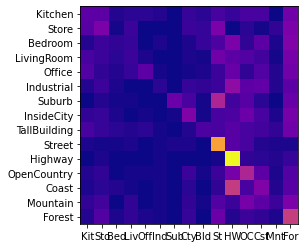

In [8]:
# Change feature and classifier
feature = 'tiny_image'     # options: 'placeholder', 'tiny_image', 'bag_of_words'
classifier = 'nearest_neighbor'  # options: 'placeholder', 'nearest_neighbor', 'support_vector_machine'
load_vocab = 'False'         # options: 'True' or 'False'
projSceneRecBoW(feature, classifier, load_vocab)

**Bag of words (Spatial Pyramid) with Support vector machine**

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Construct bags of sifts...
Construct bags of sifts...
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 74.400%
Wrote results page to results_webpage/index.html.


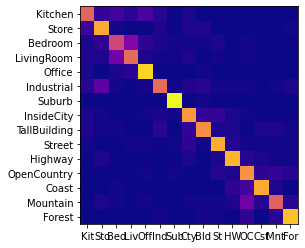

In [31]:
# Change feature and classifier
feature = 'bag_of_words'     # options: 'placeholder', 'tiny_image', 'bag_of_words'
classifier = 'support_vector_machine'  # options: 'placeholder', 'nearest_neighbor', 'support_vector_machine'
load_vocab = 'False'         # options: 'True' or 'False'
projSceneRecBoW(feature, classifier, load_vocab)

**Bag of words (Spatial Pyramid) with Support vector machine, load vocab is set to False**

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Construct bags of sifts...
Construct bags of sifts...
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 74.400%
Wrote results page to results_webpage/index.html.


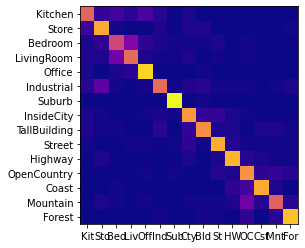

In [13]:
# Change feature and classifier
feature = 'bag_of_words'     # options: 'placeholder', 'tiny_image', 'bag_of_words'
classifier = 'support_vector_machine'  # options: 'placeholder', 'nearest_neighbor', 'support_vector_machine'
load_vocab = 'True'         # options: 'True' or 'False'
projSceneRecBoW(feature, classifier, load_vocab)

**Bag of words (Spatial Pyramid) with nearest neighbors classifier**

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Construct bags of sifts...
Construct bags of sifts...
Using nearest_neighbor classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 51.400%
Wrote results page to results_webpage/index.html.


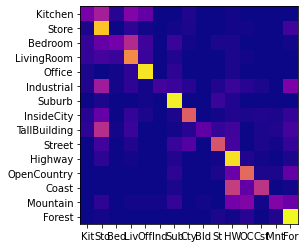

In [14]:
# Change feature and classifier
feature = 'bag_of_words'     # options: 'placeholder', 'tiny_image', 'bag_of_words'
classifier = 'nearest_neighbor'  # options: 'placeholder', 'nearest_neighbor', 'support_vector_machine'
load_vocab = 'True'         # options: 'True' or 'False'
projSceneRecBoW(feature, classifier, load_vocab)